In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, make_scorer, classification_report


In [ ]:
# Load dataset
path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
df = pd.read_csv(path, header=None)
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]


2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc(model, y_test, X_test):
    # Get predicted probabilities
    y_pred_probs = model.predict(X_test)  # Predicted probabilities for each class

    # Dynamically determine the number of classes
    num_classes = y_pred_probs.shape[1]

    # Binarize the true labels (One-hot encoding of y_test)
    y_test_bin = label_binarize(y_test.argmax(axis=1), classes=np.arange(num_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Compute micro-average ROC-AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    plt.plot(fpr_micro, tpr_micro, color='blue', linestyle='--',
             lw=2, label=f'Micro-average (AUC = {roc_auc_micro:.2f})')


    # Finalizing the plot
    plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve for Decision Tree")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [ ]:
# Step 1: Load and preprocess the data
def preprocess_data(df):
    #df.drop_duplicates(keep='first', inplace = True)

    # Handle categorical data (assuming 'protocol_type', 'service', etc., are categorical)
    categorical_cols = ['protocol_type', 'service', 'flag']
    df = pd.get_dummies(df, columns=categorical_cols)

    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    #df["label"] = df["label"].astype('category').cat.codes
    num_classes = len(label_encoder.classes_)

    # Separate features and target
    X = df.drop('label', axis=1).values
    y = to_categorical(df['label'], num_classes=num_classes)

    # Normalize numerical features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y, num_classes

# Step 2: Create the RNN model
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train and evaluate the model
def train_model(X_train, y_train, num_classes):

    # Reshape for LSTM (3D input)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

    # Create model
    model = create_rnn_model((X_train.shape[1], X_train.shape[2]), num_classes)

    # Train model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

    model.save("intrusion_detection_model.keras")

    return model, history



In [ ]:
def evaluate_model(model, X_test, y_test):

    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Evaluate model
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    print(y_pred.shape)
    print(y)

    # Calculate and print metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\nConfusion Matrix:")
    print(conf_matrix)

    print(f"\nAccuracy: {accuracy:.5f}")
    print(f"F1 Score: {f1:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    if len(np.unique(y_test)) == 1:
      print("ROC-AUC cannot be calculated as only one class is present in y_test.")
    else:
      print("ROC-AUC Score:", roc_auc_score(y_test, model.predict(X_test), multi_class='ovr'))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    plot_roc(model, y_test, X_test)

In [ ]:
X, y, num_classes = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y.argmax(axis=1), random_state=42)
model, history = train_model(X_train, y_train, num_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9886 - loss: 0.1016 - val_accuracy: 0.9985 - val_loss: 0.0088
Epoch 2/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9984 - loss: 0.0096 - val_accuracy: 0.9988 - val_loss: 0.0072
Epoch 3/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9986 - loss: 0.0073 - val_accuracy: 0.9987 - val_loss: 0.0102
Epoch 4/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9987 - loss: 0.0084 - val_accuracy: 0.9988 - val_loss: 0.0136
Epoch 5/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 0.9990 - val_loss: 0.0171
Epoch 6/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9989 - loss: 0.0104 - val_accuracy: 0.9991 - val_loss: 0.0121
Epoch 7/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9988 - loss: 0.0090 - val_accuracy: 0.9991 - val_loss: 0.0170
Epoch 8/20
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9989 - loss: 0

In [ ]:
from tensorflow.keras.models import load_model

X, y, num_classes = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y.argmax(axis=1), random_state=42)
model = load_model("intrusion_detection_model.keras")

4632/4632 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
(148207,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Confusion Matrix:
[[  657     0     0     0     0     0     0     0     0     0     0     4
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     1     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0    15     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     3
      0     0     0     1     0     0     0     0     0     0     0]
 [    0     0     0     0     0   362     0     0     0  

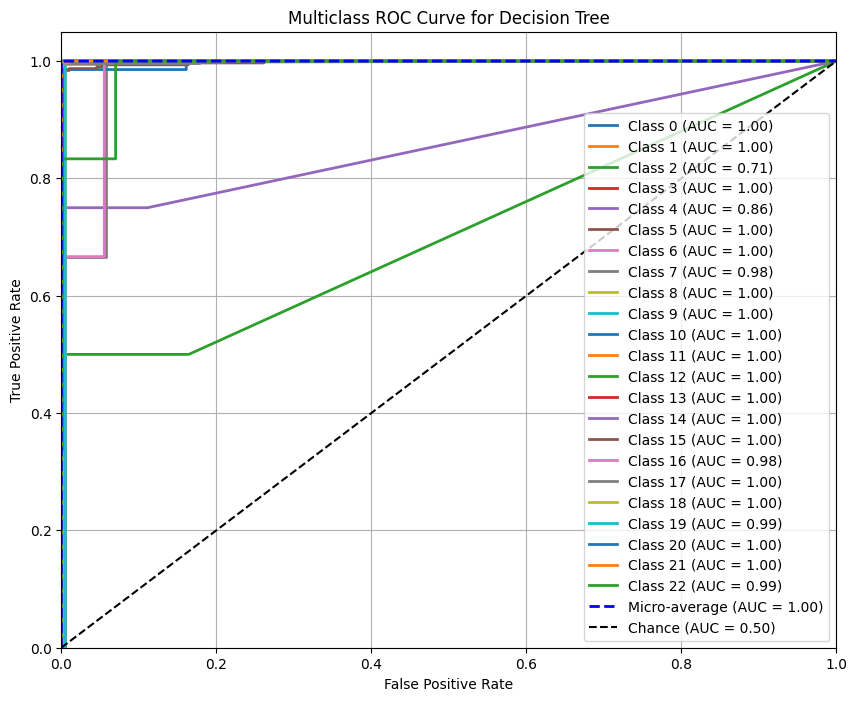

In [ ]:
evaluate_model(model, X_test, y_test)